# Retrieval vor AI with chroma

## Understand the embedding model

The embedding model - i.e. sentence transformers -  has a limited context window width. It uses 256 characters. That's the maximum context window length of the embedding model. 

Note: typically an embedding model will simply truncate any characters or tokens that are beyond its context window.

The Sentence Transformer Embedding Model is essentially an extension of the BERT transformer architecture. 
The BERT architecture embeds each token individually in a dense vector.

Sentence Transformer allows to embed entire sentences or even small documents like we have here by pooling the output of all the token embeddings to produce a single dense vector per document or in our case, per chunk. 
Sentence transformers are great as an embedding model. They're  open source, all the weights are available online, and they're really easy to run locally.

In essence with the RAG loop, we're turning GPT from a model that remembers facts into a model that processes information.

In [5]:
# import
import chromadb # chromadb is a python client for ChromaDB
import openai
from openai import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
from pypdf import PdfReader
from tqdm import tqdm # progress bar


def word_wrap(string, n_chars=72):
    # Wrap a string at the next space after n_chars
    if len(string) < n_chars:
        return string
    else:
        return string[:n_chars].rsplit(' ', 1)[0] + '\n' + word_wrap(string[len(string[:n_chars].rsplit(' ', 1)[0])+1:], n_chars)


In [48]:
reader = PdfReader("docs/microsoft_annual_report_2022.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

print(word_wrap(pdf_texts[0]))

1 Dear shareholders, colleagues, customers, and partners:  
We are
living through a period of historic economic, societal, and
geopolitical change. The world in 2022 looks nothing like 
the world in
2019. As I write this, inflation is at a 40 -year high, supply chains
are stretched, and the war in Ukraine is 
ongoing. At the same time, we
are entering a technological era with the potential to power awesome
advancements 
across every sector of our economy and society. As the
world’s largest software company, this places us at a historic

intersection of opportunity and responsibility to the world around us.
 
Our mission to empower every person and every organization on the
planet to achieve more has never been more 
urgent or more necessary.
For all the uncertainty in the world, one thing is clear: People and
organizations in every 
industry are increasingly looking to digital
technology to overcome today’s challenges and emerge stronger. And no

company is better positioned to help th

In [3]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(word_wrap(character_split_texts[10]))
print(f"\nTotal chunks: {len(character_split_texts)}")

increased, due in large part to significant global datacenter
expansions and the growth in Xbox sales and usage. Despite 
these
increases, we remain dedicated to achieving a net -zero future. We
recognize that progress won’t always be linear, 
and the rate at which
we can implement emissions reductions is dependent on many factors that
can fluctuate over time.  
On the path to becoming water positive, we
invested in 21 water replenishment projects that are expected to
generate 
over 1.3  million cubic meters of volumetric benefits in nine
water basins around the world. Progress toward our zero waste

commitment included diverting more than 15,200 metric tons of solid
waste otherwise headed to landfills and incinerators, 
as well as
launching new Circular Centers to increase reuse and reduce e -waste at
our datacenters.  
We contracted to protect over 17,000 acres of land
(50% more than the land we use to operate), thus achieving our

Total chunks: 347


In [4]:
# Chunk the texts into smaller pieces - i.e. 256 tokens
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(word_wrap(token_split_texts[10]))
print(f"\nTotal chunks: {len(token_split_texts)}")

/opt/dev/miniconda3/envs/llm/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


increased, due in large part to significant global datacenter
expansions and the growth in xbox sales and usage. despite these
increases, we remain dedicated to achieving a net - zero future. we
recognize that progress won ’ t always be linear, and the rate at which
we can implement emissions reductions is dependent on many factors that
can fluctuate over time. on the path to becoming water positive, we
invested in 21 water replenishment projects that are expected to
generate over 1. 3 million cubic meters of volumetric benefits in nine
water basins around the world. progress toward our zero waste
commitment included diverting more than 15, 200 metric tons of solid
waste otherwise headed to landfills and incinerators, as well as
launching new circular centers to increase reuse and reduce e - waste
at our datacenters. we contracted to protect over 17, 000 acres of land
( 50 % more than the land we use to operate ), thus achieving our

Total chunks: 349


In [5]:
# Load the embeddings into ChromaDB
embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[[0.04256267473101616, 0.03321181610226631, 0.030340107157826424, -0.034866541624069214, 0.068416528403759, -0.08090914040803909, -0.015474438667297363, -0.0014508804306387901, -0.016744449734687805, 0.06770770251750946, -0.050541408360004425, -0.049195315688848495, 0.05139995366334915, 0.09192728251218796, -0.07177838683128357, 0.039519697427749634, -0.012833574786782265, -0.024947505444288254, -0.04622867330908775, -0.024357536807656288, 0.03394966199994087, 0.025502454489469528, 0.027317089959979057, -0.004126230254769325, -0.03633837774395943, 0.003690865822136402, -0.02743045799434185, 0.004796704277396202, -0.028896218165755272, -0.018870718777179718, 0.03666624799370766, 0.02569587714970112, 0.03131282702088356, -0.06393436342477798, 0.05394405126571655, 0.08225346356630325, -0.041756875813007355, -0.006995770614594221, -0.02348596416413784, -0.030747978016734123, -0.002979153534397483, -0.0779094472527504, 0.009353147819638252, 0.003162873676046729, -0.022257091477513313, -0.01

In [6]:
chroma_client = chromadb.Client()
chroma_client.list_collections()

[]

In [21]:
# only run if collection already exists
chroma_client.delete_collection("microsoft_annual_report_2022")
chroma_client.list_collections()

[]

In [7]:
# create a collection
chroma_collection = chroma_client.create_collection("microsoft_annual_report_2022", embedding_function=embedding_function)
# create ids for each chunk
ids = [str(i) for i in range(len(token_split_texts))]
# add the chunks to the collection
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

349

In [8]:
# query the collection
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(word_wrap(document))
    print('\n')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.


74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in milli

In [9]:
print(openai.VERSION)

1.10.0


In [10]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv('.env')) # read local .env file
openai.api_key  = os.environ['OPENAI_API_KEY']
openai_client = OpenAI()

In [12]:
def rag(query, retrieved_documents, model="gpt-3.5-turbo"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual report."
            "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]
    # create the completion request to OpenAI
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    # get the response from the first choice
    content = response.choices[0].message.content
    return content

In [13]:
output = rag(query=query, retrieved_documents=retrieved_documents)

print(word_wrap(output))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The total revenue for the year ended June 30, 2022, as stated in the
income statement, is $198,270 million.


## Pitfalls

you need  `umap-learn`

In the example embeddings have 348 dimensions. In order to visualize for humans let's project them down into two dimensions, and this can be useful for reasoning about the structure of embedding space. [UMAP](https://umap-learn.readthedocs.io/en/latest/) is Uniform Manifold Approximation. This is 
a similar technique to something like PCA or t-SNE, except UMAP explicitly  tries to preserve the structure of the data in terms of the distances between points as much as it can, unlike for example, PCA, which tries to find the predominant directions.

In [6]:
# helper functions, see section above how to handle embeddings

import chromadb

from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
import numpy as np
from pypdf import PdfReader
from tqdm import tqdm


def read_pdf(filename):
    reader = PdfReader(filename)
    
    pdf_texts = [p.extract_text().strip() for p in reader.pages]

    # Filter the empty strings
    pdf_texts = [text for text in pdf_texts if text]
    return pdf_texts


def chunk_texts(texts):
    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=1000,
        chunk_overlap=0
    )
    character_split_texts = character_splitter.split_text('\n\n'.join(texts))

    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

    token_split_texts = []
    for text in character_split_texts:
        token_split_texts += token_splitter.split_text(text)

    return token_split_texts


def load_chroma(filename, collection_name, embedding_function):
    texts = read_pdf(filename)
    chunks = chunk_texts(texts)

    chroma_cliet = chromadb.Client()
    chroma_collection = chroma_cliet.create_collection(name=collection_name, embedding_function=embedding_function)

    ids = [str(i) for i in range(len(chunks))]

    chroma_collection.add(ids=ids, documents=chunks)

    return chroma_collection

def word_wrap(string, n_chars=72):
    # Wrap a string at the next space after n_chars
    if len(string) < n_chars:
        return string
    else:
        return string[:n_chars].rsplit(' ', 1)[0] + '\n' + word_wrap(string[len(string[:n_chars].rsplit(' ', 1)[0])+1:], n_chars)

   
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [2]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='docs/microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

/opt/dev/miniconda3/envs/llm/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


349

In [3]:
import umap as mp
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = mp.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/opt/dev/miniconda3/envs/llm/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
# project the embeddings into 2D  
def project_embeddings(embeddings, umap_transform) -> np.ndarray:
    # create an empty array to store the projected embeddings
    umap_embeddings = np.empty((len(embeddings),2))
    # loop through each embedding and project it into 2D
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings  

In [6]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [01:41<00:00,  3.44it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(-4.14157487154007, 7.448055040836334, 5.867360353469849, 11.475993871688843)

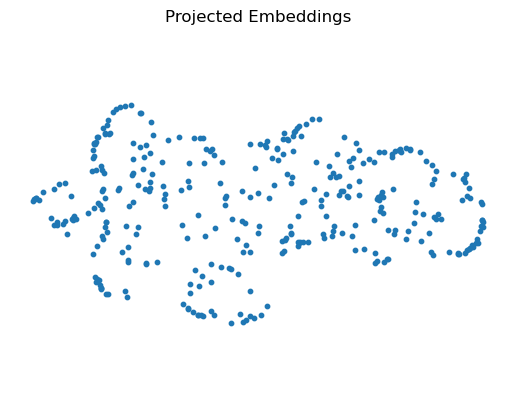

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

### Relevancy and Distraction

Evaluating the quality and performance of a retrieval system is about relevancy and distraction.

The embedding model that we use to embed queries and embed our data does not have any knowledge of the task or query we're trying to answer at the time we actually retrieve the information. So the reason that a retrieval system may not perform the way that we expect is because we're asking it to perform a specific task using only a general representation. And that makes things more complicated.

Query: "What has been the investment in research and development?"
Here there are also distractors in this result. A distractor is a result that is not actually relevant to the query. The problem is that information is passed to the large language model which is not relevant to the query. In effect the model tends to get distracted by this information and output suboptimal results. Distractors are very difficult to diagnose and debug, both for the user, but also for developers and engineers building 
these types of systems. 

An exterme example is the query about Michael Jordan: the query is totally irrelevant to any of the data that we have in our data set. 

So it's very important to make your retrieval system robust and return relevant results and no distracting results to the model.

In [8]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in millio

In [9]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


(-4.14157487154007, 7.448055040836334, 5.867360353469849, 11.475993871688843)

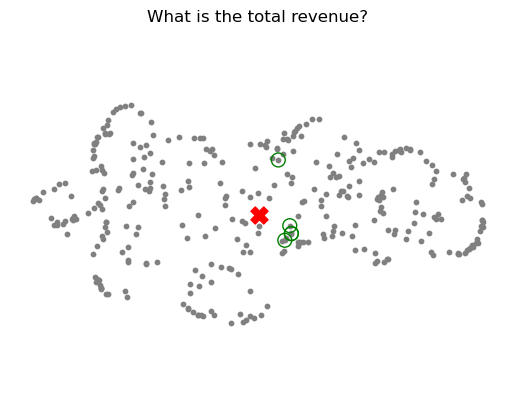

In [10]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [11]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

culture of trust can help navigate the challenges the world faces
today. organizations of all sizes have digitized business - critical
functions, redefining what they can expect from their business
applications. customers are looking to unlock value while simplifying
security and management. from infrastructure and data, to business
applications and collaboration, we provide unique, differentiated value
to customers. we are building a distributed computing fabric – across
cloud and the edge – to help every organization build, run, and manage
mission - critical workloads anywhere. in the next phase of innovation,
artificial intelligence ( “ ai ” ) capabilities are rapidly advancing,
fueled by data and knowledge of the world. we are enabling metaverse
experiences at all layers of our stack, so customers can more
effectively model, automate, simulate, and predict changes within their
industrial

every organization turn its data into predictive and analytical power.
with our new microsoft 

In [12]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


(-4.14157487154007, 7.448055040836334, 5.867360353469849, 11.475993871688843)

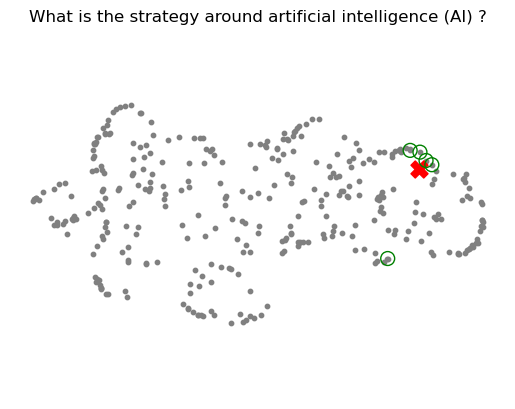

In [13]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [19]:
query = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

• operating expenses increased $ 1. 5 billion or 14 % driven by
investments in gaming, search and news advertising, and windows
marketing. operating expenses research and development ( in millions,
except percentages ) 2022 2021 percentage change research and
development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 %
0ppt research and development expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with product development. research and
development expenses also include third - party development and
programming costs, localization costs incurred to translate software
for international markets, and the amortization of purchased software
code and services content. research and development expenses increased
$ 3. 8 billion or 18 % driven by investments in cloud engineering,
gaming, and linkedin. sales and marketing

competitive in local markets and enables us to continue to attract top
talent from ac

In [14]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


(-4.14157487154007, 7.448055040836334, 5.867360353469849, 11.475993871688843)

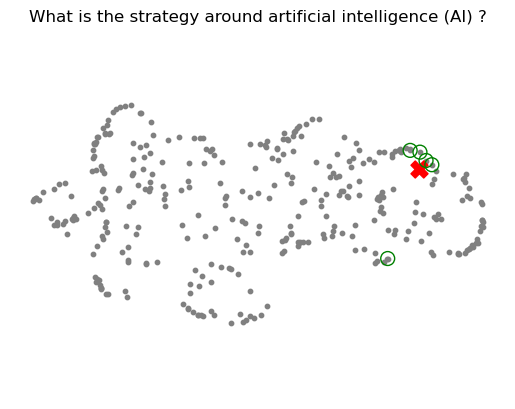

In [15]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [16]:
query = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

we use metrics in assessing the performance of our business and to make
informed decisions regarding the allocation of resources. we disclose
metrics to enable investors to evaluate progress against our ambitions,
provide transparency into performance trends, and reflect the continued
evolution of our products and services. our commercial and other
business metrics are fundamentally connected based on how customers use
our products and

our success is based on our ability to create new and compelling
products, services, and experiences for our users, to initiate and
embrace disruptive technology trends, to enter new geographic and
product markets, and to drive broad adoption of our products and
services. we invest in a range of emerging technology trends and
breakthroughs that we believe offer significant opportunities to
deliver value to our customers and growth for the company. based on our
assessment of key technology trends, we maintain our long - term
commitment to research and de

In [17]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


(-4.14157487154007, 7.448055040836334, 5.867360353469849, 11.475993871688843)

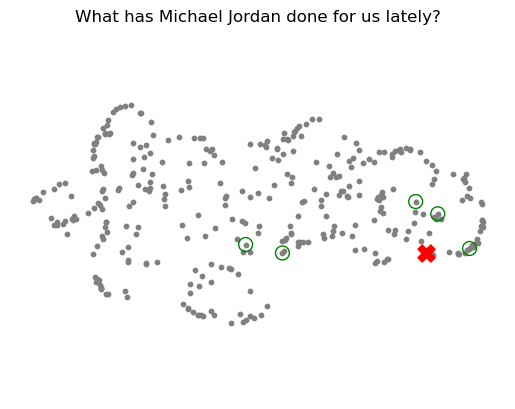

In [18]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

## Query Expansion

https://arxiv.org/abs/2305.03653

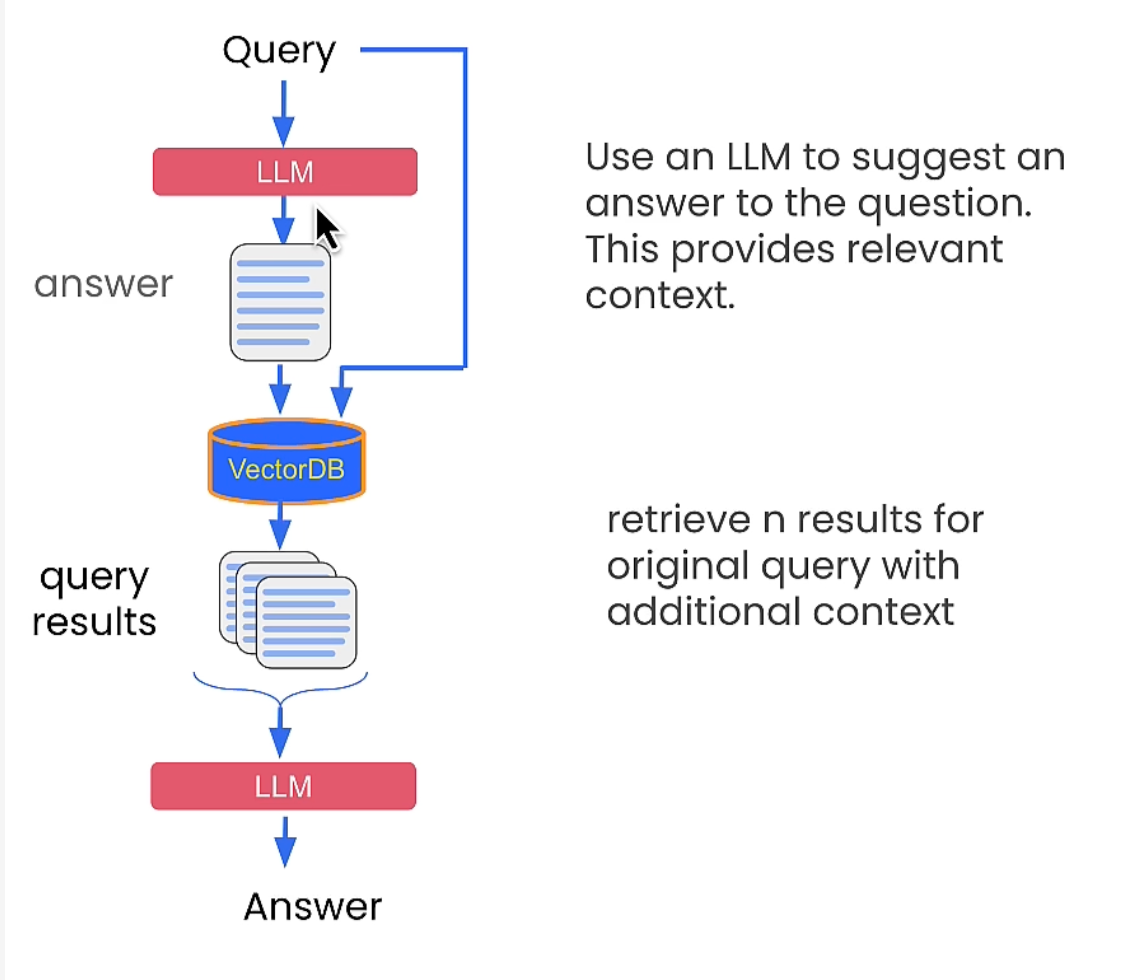


In [23]:
# if not already active in the notebook, run the following to initialize the openai python client
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [20]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = mp.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/opt/dev/miniconda3/envs/llm/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [01:40<00:00,  3.47it/s]


In [21]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [24]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Was there significant turnover in the executive team? During the fiscal
year 2019, there was a notable turnover in the executive team of XYZ
Corporation. The Chief Executive Officer (CEO) retired after serving
the company for 10 years and was succeeded by a new CEO who was
appointed in the second quarter of the year. Additionally, the Chief
Financial Officer (CFO) stepped down from his role and was replaced by
a new CFO with extensive experience in financial management. The Board
of Directors also witnessed changes with the departure of two
long-serving directors and the addition of three new members, including
a renowned industry expert. These changes in the executive team reflect
the company's commitment to refreshing its leadership and bringing in
new perspectives to drive growth and enhance shareholder value.


In [25]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

the company engaged deloitte & touche llp, an independent registered
public accounting firm, to audit and render an opinion on the
consolidated financial statements and internal control over financial
reporting in accordance with the standards of the public company
accounting oversight board ( united states ). the board of directors,
through its audit committee, consisting solely of independent directors
of the company, meets periodically with management, internal auditors,
and our independent registered public accounting firm to ensure that
each is meeting its responsibilities and to discuss matters concerning
internal controls and financial reporting. deloitte & touche llp and
the internal auditors each have full and free access to the audit
committee. satya nadella chief executive officer amy e. hood executive
vice president and chief financial officer alice l. jolla corporate
vice president and chief accounting officer

89 directors and executive officers of microsoft corporation d

In [26]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


(-4.14157487154007, 7.448055040836334, 5.867360353469849, 11.475993871688843)

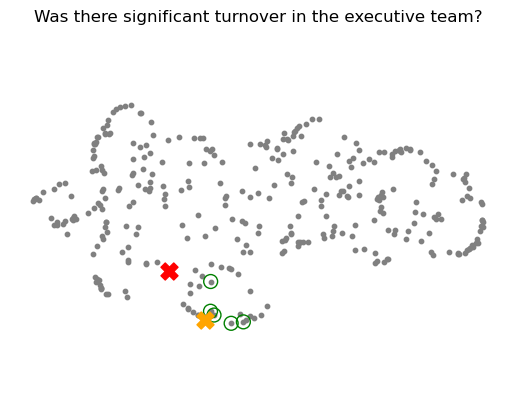

In [27]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

### Expansion with multiple queries

we generate multiple related queries using an LLM, gives us a better chance to capture all related informations.

In [28]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [29]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What were the key factors that influenced revenue growth?
What were the main drivers behind the increase in revenue?
What product or service lines experienced the highest revenue growth?
Were there any significant changes in pricing strategies that contributed to the increase in revenue?
Did changes in market demand or consumer behavior play a role in the revenue increase?


In [30]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [31]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


In [32]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:08<00:00,  3.56it/s]


(-4.14157487154007, 7.448055040836334, 5.867360353469849, 11.475993871688843)

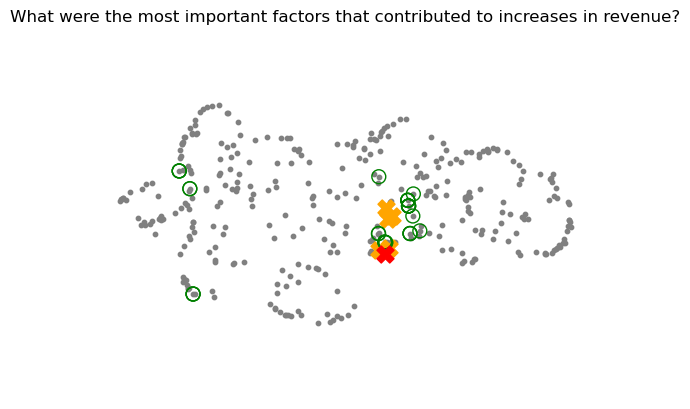

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Cross-encorder re-ranking

Cross-encoder re-ranking to scores the relevancy of the retrieved results for the query that has been sent. In re-ranking, after you retrieve results for a particular query, you pass these results along with your query to a re-ranking model. This allows you to re-rank the output 
so the most relevant results have the highest rank.

Sentence transformers are made up of two kinds of models:
- a Bi-encoder, where a Bi-encoder encodes queries separately, 
- and then we can use the output of the Bi-encoders to perform cosine similarity and find the nearest neighbors.


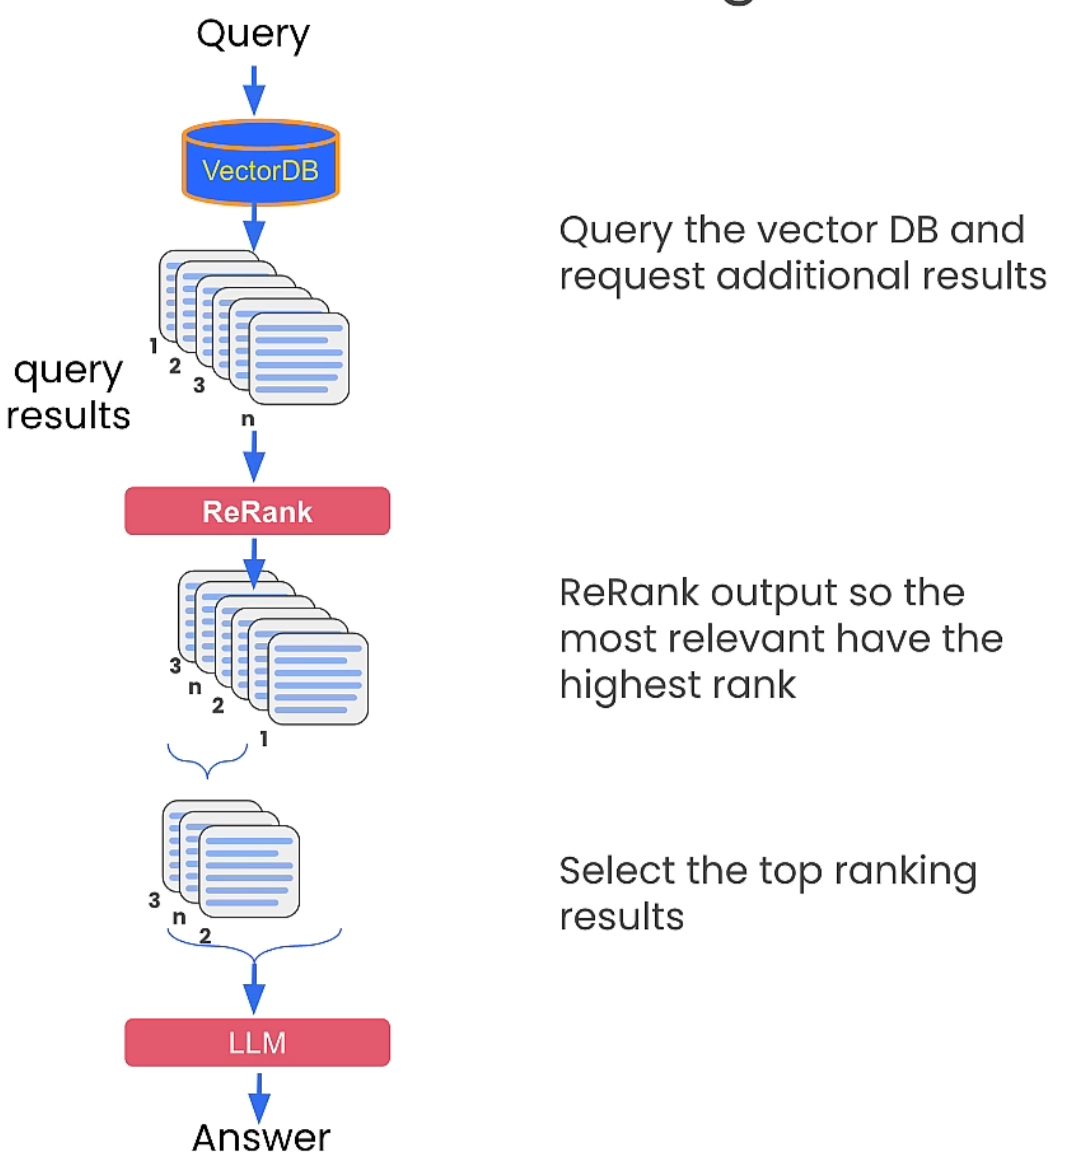

In [36]:
chroma_client = chromadb.Client()
chroma_client.list_collections()

[Collection(name=microsoft_annual_report_2022)]

In [37]:
# only run if collection already exists

chroma_client.delete_collection("microsoft_annual_report_2022")
chroma_client.list_collections()

[]

In [38]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='docs/microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

349

In [39]:
query = "What has been the investment in research and development?"
# now get 10 results
results = chroma_collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

• operating expenses increased $ 1. 5 billion or 14 % driven by
investments in gaming, search and news advertising, and windows
marketing. operating expenses research and development ( in millions,
except percentages ) 2022 2021 percentage change research and
development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 %
0ppt research and development expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with product development. research and
development expenses also include third - party development and
programming costs, localization costs incurred to translate software
for international markets, and the amortization of purchased software
code and services content. research and development expenses increased
$ 3. 8 billion or 18 % driven by investments in cloud engineering,
gaming, and linkedin. sales and marketing

competitive in local markets and enables us to continue to attract top
talent from ac

In [40]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [41]:
pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)
print("Scores:")
for score in scores:
    print(score)

Scores:
0.98693466
2.644579
-0.26802942
-10.73159
-7.7066045
-5.6469955
-4.297035
-10.933233
-7.0384283
-7.3246956


In [42]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o)

New Ordering:
1
0
2
6
5
8
9
4
3
7


### Re-ranking


The cross-encoder re-ranker can emphasize different parts of the query than the embedding model does. And so the ranking that it provides is much more conditional on the specific query than just what is naively returned by the retrieval system itself.

Cross encoder


In [43]:
original_query = "What were the most important factors that contributed to increases in revenue?"
generated_queries = [
    "What were the major drivers of revenue growth?",
    "Were there any new product launches that contributed to the increase in revenue?",
    "Did any changes in pricing or promotions impact the revenue growth?",
    "What were the key market trends that facilitated the increase in revenue?",
    "Did any acquisitions or partnerships contribute to the revenue growth?"
]

In [44]:
queries = [original_query] + generated_queries

results = chroma_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [45]:
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

In [46]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [47]:
scores = cross_encoder.predict(pairs)

In [48]:
print("Scores:")
for score in scores:
    print(score)

Scores:
-10.711212
-10.042844
-6.90209
-9.918428
-3.794862
-10.148884
-7.754099
-9.80788
-10.0839405
-4.651892
-9.357721
-1.136996
-4.8184834
-5.141832
-7.9171767
-10.00014
-9.768024
-3.7681527
-5.2747498
-8.505108
-4.3417683
-7.4906564


In [49]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o)

New Ordering:
11
17
4
20
9
12
13
18
2
21
6
14
19
10
16
7
3
15
1
8
5
0


## Embedding Adopters

<img src="./img/embedding%20adoptors.png" width="500" height="300">

Embedding adapters are a way to alter the embedding of a query directly in order to produce better retrieval results. 
We train the embedding adapter using user feedback on the relevancy of our retrieved results for 
a set of queries. 

Torch is used in order to train a model, but a very lightweight one. And we create our embedding function and load everything into Chroma.


In [12]:
import torch
import umap as mp
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [7]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='docs/microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


349

In [13]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = mp.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/opt/dev/miniconda3/envs/llm/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 349/349 [01:45<00:00,  3.31it/s]


In [15]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [17]:
# create a datasez

def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [19]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


1. What is the company's overall financial performance and profitability?
2. How has the company's revenue trended over the past few years?
3. What are the company's major sources of revenue?
4. What are the company's total assets and liabilities?
5. How much debt does the company have, and what are the terms of that debt?
6. What is the company's operating cash flow and free cash flow?
7. How is the company managing its working capital?
8. What is the company's dividend policy, and how does it compare to its earnings?
9. What are the company's major expenses, and how have they changed over time?
10. What are the company's major risks and uncertainties?
11. How does the company's financial position compare to its competitors?
12. What is the company's operating margin and net profit margin?
13. What is the company's return on assets and return on equity?
14. Has the company been involved in any legal disputes or regulatory actions?
15. What are the company's future growth prospects and

In [20]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [21]:
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

In [22]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [25]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [26]:
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [01:22<00:00,  5.49s/it]


In [38]:
len(adapter_labels)

150

In [39]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [40]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

In [41]:
# setting up the model
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [42]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [43]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

  0%|          | 0/100 [00:00<?, ?it/s]/opt/dev/miniconda3/envs/llm/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:02<00:00, 35.06it/s]


In [44]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.5144663453102112


In [45]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

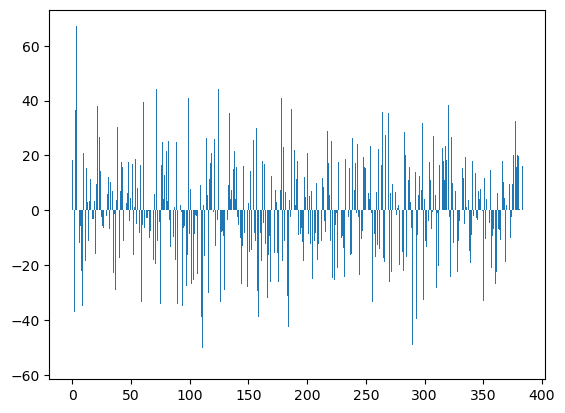

In [46]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


In [47]:
uery_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


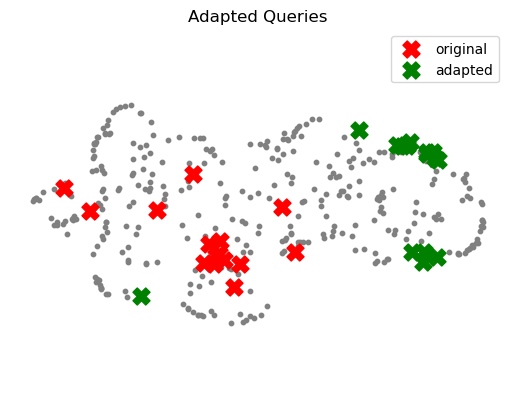

In [37]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()